In [1]:
from IPython.display import Image

<font color='red'>
**Note:** This notebook is a work in progress and serves as a first viable proof of concept. There might be bugs! 🐞
</font>

# Hello, Queneau?

Welcome to this exploration of literary style and the capabilities of large language models (LLMs) in understanding and recognizing it. Much of the existing literature on style transfer in AI focuses on the technical capabilities of these models. However, a critical aspect often overlooked is how well a language model truly "understands" (by lack of a better word) literary style. Can it discern and interpret stylistic nuances? Answering these questions could provide insights into the abilities of AI (specifically LLMs), particularly in tasks related to the recognition and classification of literary styles.

## Table of Contents

1. [_Exercises de Style_](#Exercises-de-Style-by-Raymond-Queneau)
2. [Inspecting the Data](#Exploring-the-Data)
3. [Experiment #1](#Experiment-#1)
4. [Experiment #2](#Experiment-#2)
5. [Experiment #3](#Experiment-#3)
6. [Notes](#Notes)
7. [Notes and References](#Notes-and-References)

## _Exercises de Style_ by Raymond Queneau

In this notebook, we will conduct several experiments centered around Raymond Queneau's _Exercises de Style_." First published in 1947, this collection presents the same narrative rewritten in 99 unique styles, making it a perfect testbed for our exploration.

Some key points about this dataset:

- all stories are penned by Queneau, originally in French, as a form of stylistic practice, hence the title;
- the original collection includes 99 variations on a simple story about a man encountering another man on the bus, who irritates him;
- [25 or 45 exercises added later? -- look up this reference!];
- the stories are short, allowing us to conduct numerous experiments efficiently without worrying (too much) about prompt or token restrictions common in LLMs;
- each story is titled in a way that reflects its style, though some titles are more straightforward than others: "sonnet", "alexandrines", "Cockney", "precision", "anagrams", etc.;
- the stories have been translated into over 35 languages (!), offering a unique opportunity to examine how LLMs perform across different languages;
- Barbara Wrigth -- the translator of the English version -- identifies 7 different groups of styles: types of speech, types of written prose, poetry styles, character sketches, experiments with grammar and rhetoric, jargon, and miscellaneous. This classification could be useful for our experiments (?).

While exploring translations of the French original, we might wonder whether translators preserved the original stylistic features or actually introduced new styles, i.e. turning translations into adaptations. But before we complicating our research, let's first take a look at the data and see what we can initially do with it!

_Stefan Themerson's cover for the 1958 edition of Raymond Queneau's "Exercises in Style". Vectorized and colorized by Wouter Haverals :-)_

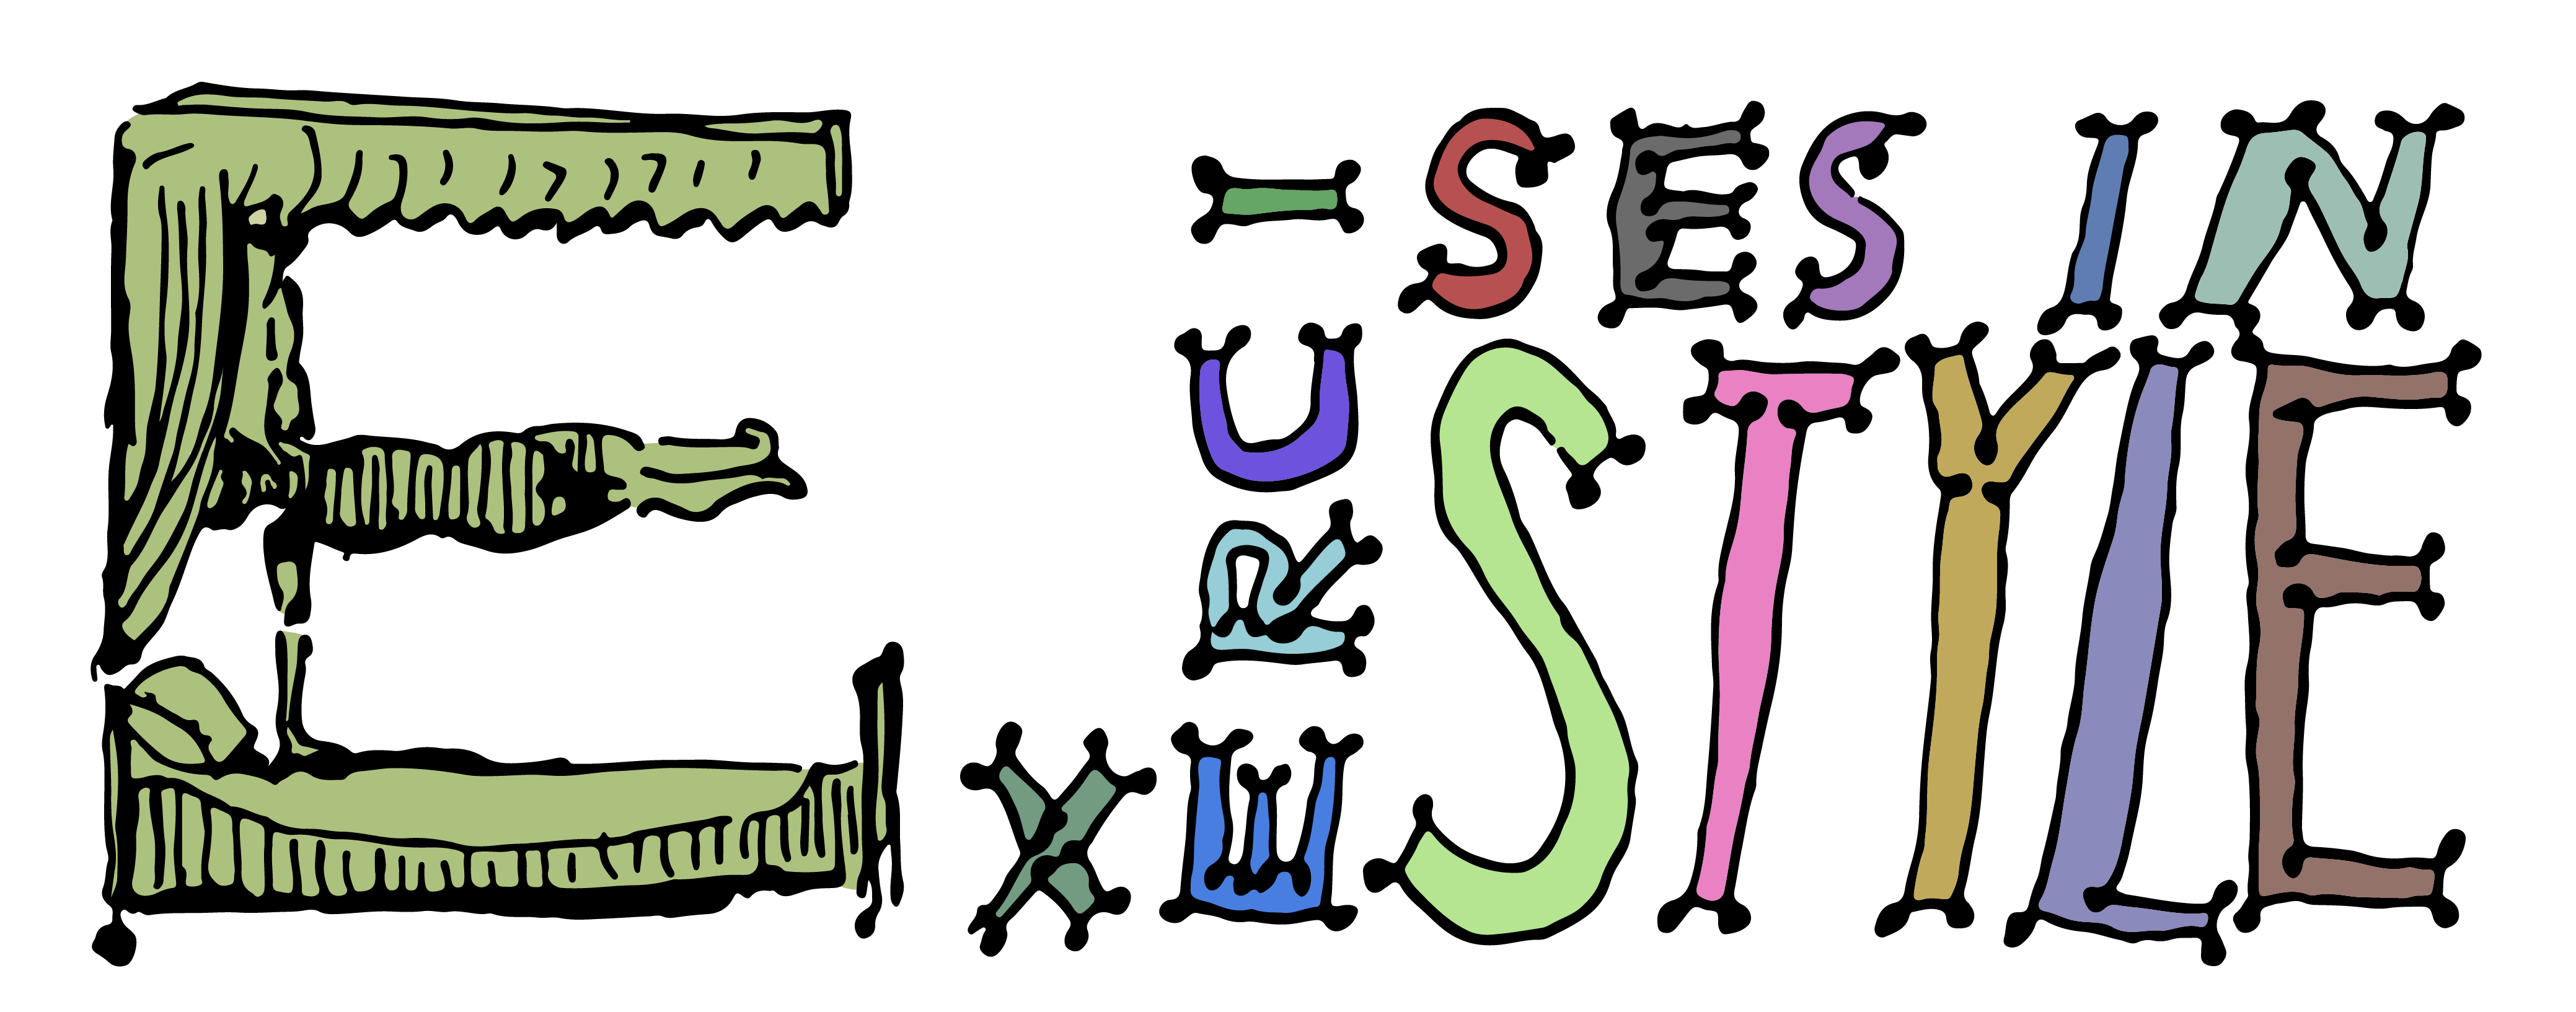

In [4]:
Image(filename='../img/ex_in_style-COLOR2.png', width="800")

_Stefan Themerson's cover for the 1958 edition of Raymond Queneau's "Exercises in Style". Vectorized and colorized by Wouter Haverals :-)_

## Inspecting the Data

The dataset `.../data/stories.csv` compiles all these stories into a comprehensive CSV file. The information contained in this file includes:

- `id` - an identifier for each story (repeated for different translations, so they link to the same original story);
- `auth` - the author; mostly, this is Queneau, but there are some exceptions (e.g. translator's own stories, homages, etc.);
- `transl` - the translator of the story;
- `lang` - the language;
- `pubdate` - the publication year;
- `story` - the story text;
- `label` - the stylistic label of the story, derived directly from the story titles.

In [1]:
import pandas as pd

# load the CSV file
df = pd.read_csv('../data/stories.csv')

# clean the 'label' column by stripping extra whitespace and removing quotes
df['label'] = df['label'].apply(lambda x: x.strip().replace("'", ""))

print(f"There are {len(df)} stories in the dataset.")
df.head(20)

There are 96 stories in the dataset.


,id,auth,transl,lang,pubdate,story,label,definition,group
0,1,Raymond Queneau,Barbara Wright,eng,1958,"In the S bus, in the rush hour. A chap of abou...",notation,NaN,NaN
1,2,Raymond Queneau,Barbara Wright,eng,1958,Towards the middle of the day and at midday I ...,double entry,NaN,NaN
2,3,Raymond Queneau,Barbara Wright,eng,1958,Some of us were travelling together. A young m...,litotes,NaN,NaN
3,4,Raymond Queneau,Barbara Wright,eng,1958,"In the centre of the day, tossed among the sho...",metaphorically,NaN,NaN
4,5,Raymond Queneau,Barbara Wright,eng,1958,You ought to put another button on your overco...,retrograde,NaN,NaN
5,6,Raymond Queneau,Barbara Wright,eng,1958,How tightly packed in we were on that bus plat...,surprises,NaN,NaN
6,7,Raymond Queneau,Barbara Wright,eng,1958,I had the impression that everything was misty...,dream,NaN,NaN
7,8,Raymond Queneau,Barbara Wright,eng,1958,When midday strikes you will be on the rear pl...,prognostication,NaN,NaN
8,9,Raymond Queneau,Barbara Wright,eng,1958,"Ridiculous young man, as I was on an S bus one...",synchysis,NaN,NaN
9,10,Raymond Queneau,Barbara Wright,eng,1958,One day I happened to be on the platform of a ...,the rainbow,NaN,NaN


### A closer look at two stories

To better understand the dataset, let's examine the first two stories as they appear in the collection (and thus also in the CSV file). These stories provide a clear demonstration of how Queneau manipulates simple narrative moments into distinct stylistic expressions.

#### Story 1: Notation

> ```plaintext
> In the S bus, in the rush hour. A chap of about 26, felt hat with a cord instead of a ribbon, neck too long, as if someone’s been having a tug-of-war with it. People getting off. The chap in question gets annoyed with one of the men standing next to him. He accuses him of jostling him every time anyone goes past. A snivelling tone which is meant to be aggressive. When he sees a vacant seat he throws himself on to it.
>
> Two hours later, I meet him in the Cour de Rome, in front of the gare Saint-Lazare. He’s with a friend who’s saying: “You ought to get an extra button put on your overcoat.” He shows him where (at the lapels) and why.
> ```

The title/label `notation` suggests a style marked by detailed, almost clinical observation, mirroring how one might jot down notes about a scene.

#### Story 2: Double Entry

> ```plaintext
> Towards the middle of the day and at midday I happened to be on and got on to the platform and the balcony at the back of an S-line and of a Contrescarpe-Champerrret bus and passenger transport vehicle which was packed and to all intents and purposes full. I saw and noticed a young man and an old adolescent who was rather ridiculous and pretty grotesque; thin neck and skinny windpipe, string and cord round his hat and tile. After a scrimmage and scuffle he says and states in a lachrymose and snivelling voice and tone that his neighbour and fellow-traveller is deliberately trying and doing his utmost to push him and obtrude himself on him every time anyone gets off and makes an exit. This having been declared and having spoken he rushes headlong and wends his way towards a vacant and a free place and seat.
>
> Two hours after and a-hundred-and-twenty minutes later, I meet him and see him again in the Cour de Rome and in front of the gare Saint-Lazare. He is with and in the company of a friend and pal who is advising and urging him to have a button and vegetable ivory disc added and sewn on to his overcoat and mantle.
> ```

It is not hard to see that this story is a variation of the first one. `Double Entry` cleverly plays with repetition and redundancy, reflecting the accounting principle of entering each transaction twice.

### Experiment #1

Now, how would a language model perform in correctly attaching these labels to their respective stories? Our experiments will challenge a state-of-the-art language model to predict the correct label based on the narrative content provided. This involves systematically varying the label space (i.e. the number of possible labels presented to the model), from a limited set of two to $n$ story-label pairs.

By evaluating the model's performance across different configurations, we aim to understand better how model accuracy is influenced by the complexity and size of the label set. This approach not only tests the model's capability to recognize and classify textual styles but also helps in discerning the influence of label quantity on decision-making processes in AI.

Our experiments will be structured as follows:

1. We randomly select $n$ labels and their corresponding stories from the full sotry dataset
   
2. Next, we present the model with one of these stories together with the set of labels it *must* choose from. In other words, the model will see one story at a time, and it will have to choose the correct label from the list of labels. For our example where the model has to choose between `notation` and `double entry`, the prompts and possible outputs might look like this:

> ```plaintext
> Prompt #1: Please read the following story and assign the most appropriate label from these options: 'notation', 'double entry'. Respond with only the label name. For example, if the correct label is 'metaphorocally', reply 'metaphorically'.
>
> {story-#1}
>
> Output: `notation`
> ```

> ```plaintext
> Prompt #2: Please read the following story and assign the most appropriate label from these options: 'notation', 'double entry'. Respond with only the label name. For example, if the correct label is 'metaphorocally', reply 'metaphorically'.
>
> {story-#2}
> 
> Output: `double entry`
> ```
 
3. For the same label space size, we will repeat the experiment multiple times to account because some labels might be easier to predict than others. E.g. we repeat the experiment 10 times for a label space of 2.

4. The models responses will be recorded and written to a CSV file for further analysis (see `.../results/`).
   
5. Finally, we will increase the label space size itself and repeat the process, evaluating the model's performance across different label configurations. E.g. we repeat the experiment 10 times for a label space of 3, 4, 5, ..., 99.

It's important to note that the model is presented with only one story at a time, along with the full set of potential labels for that story. It does not have the ability to compare or reference any other stories during the decision-making process! This setup means that determining the correct label from a choice of two (where one is correct and the other incorrect) is significantly simpler than selecting the correct label from a much larger set, such as 99 different options. Therefore, the task becomes increasingly challenging as the number of labels grows.

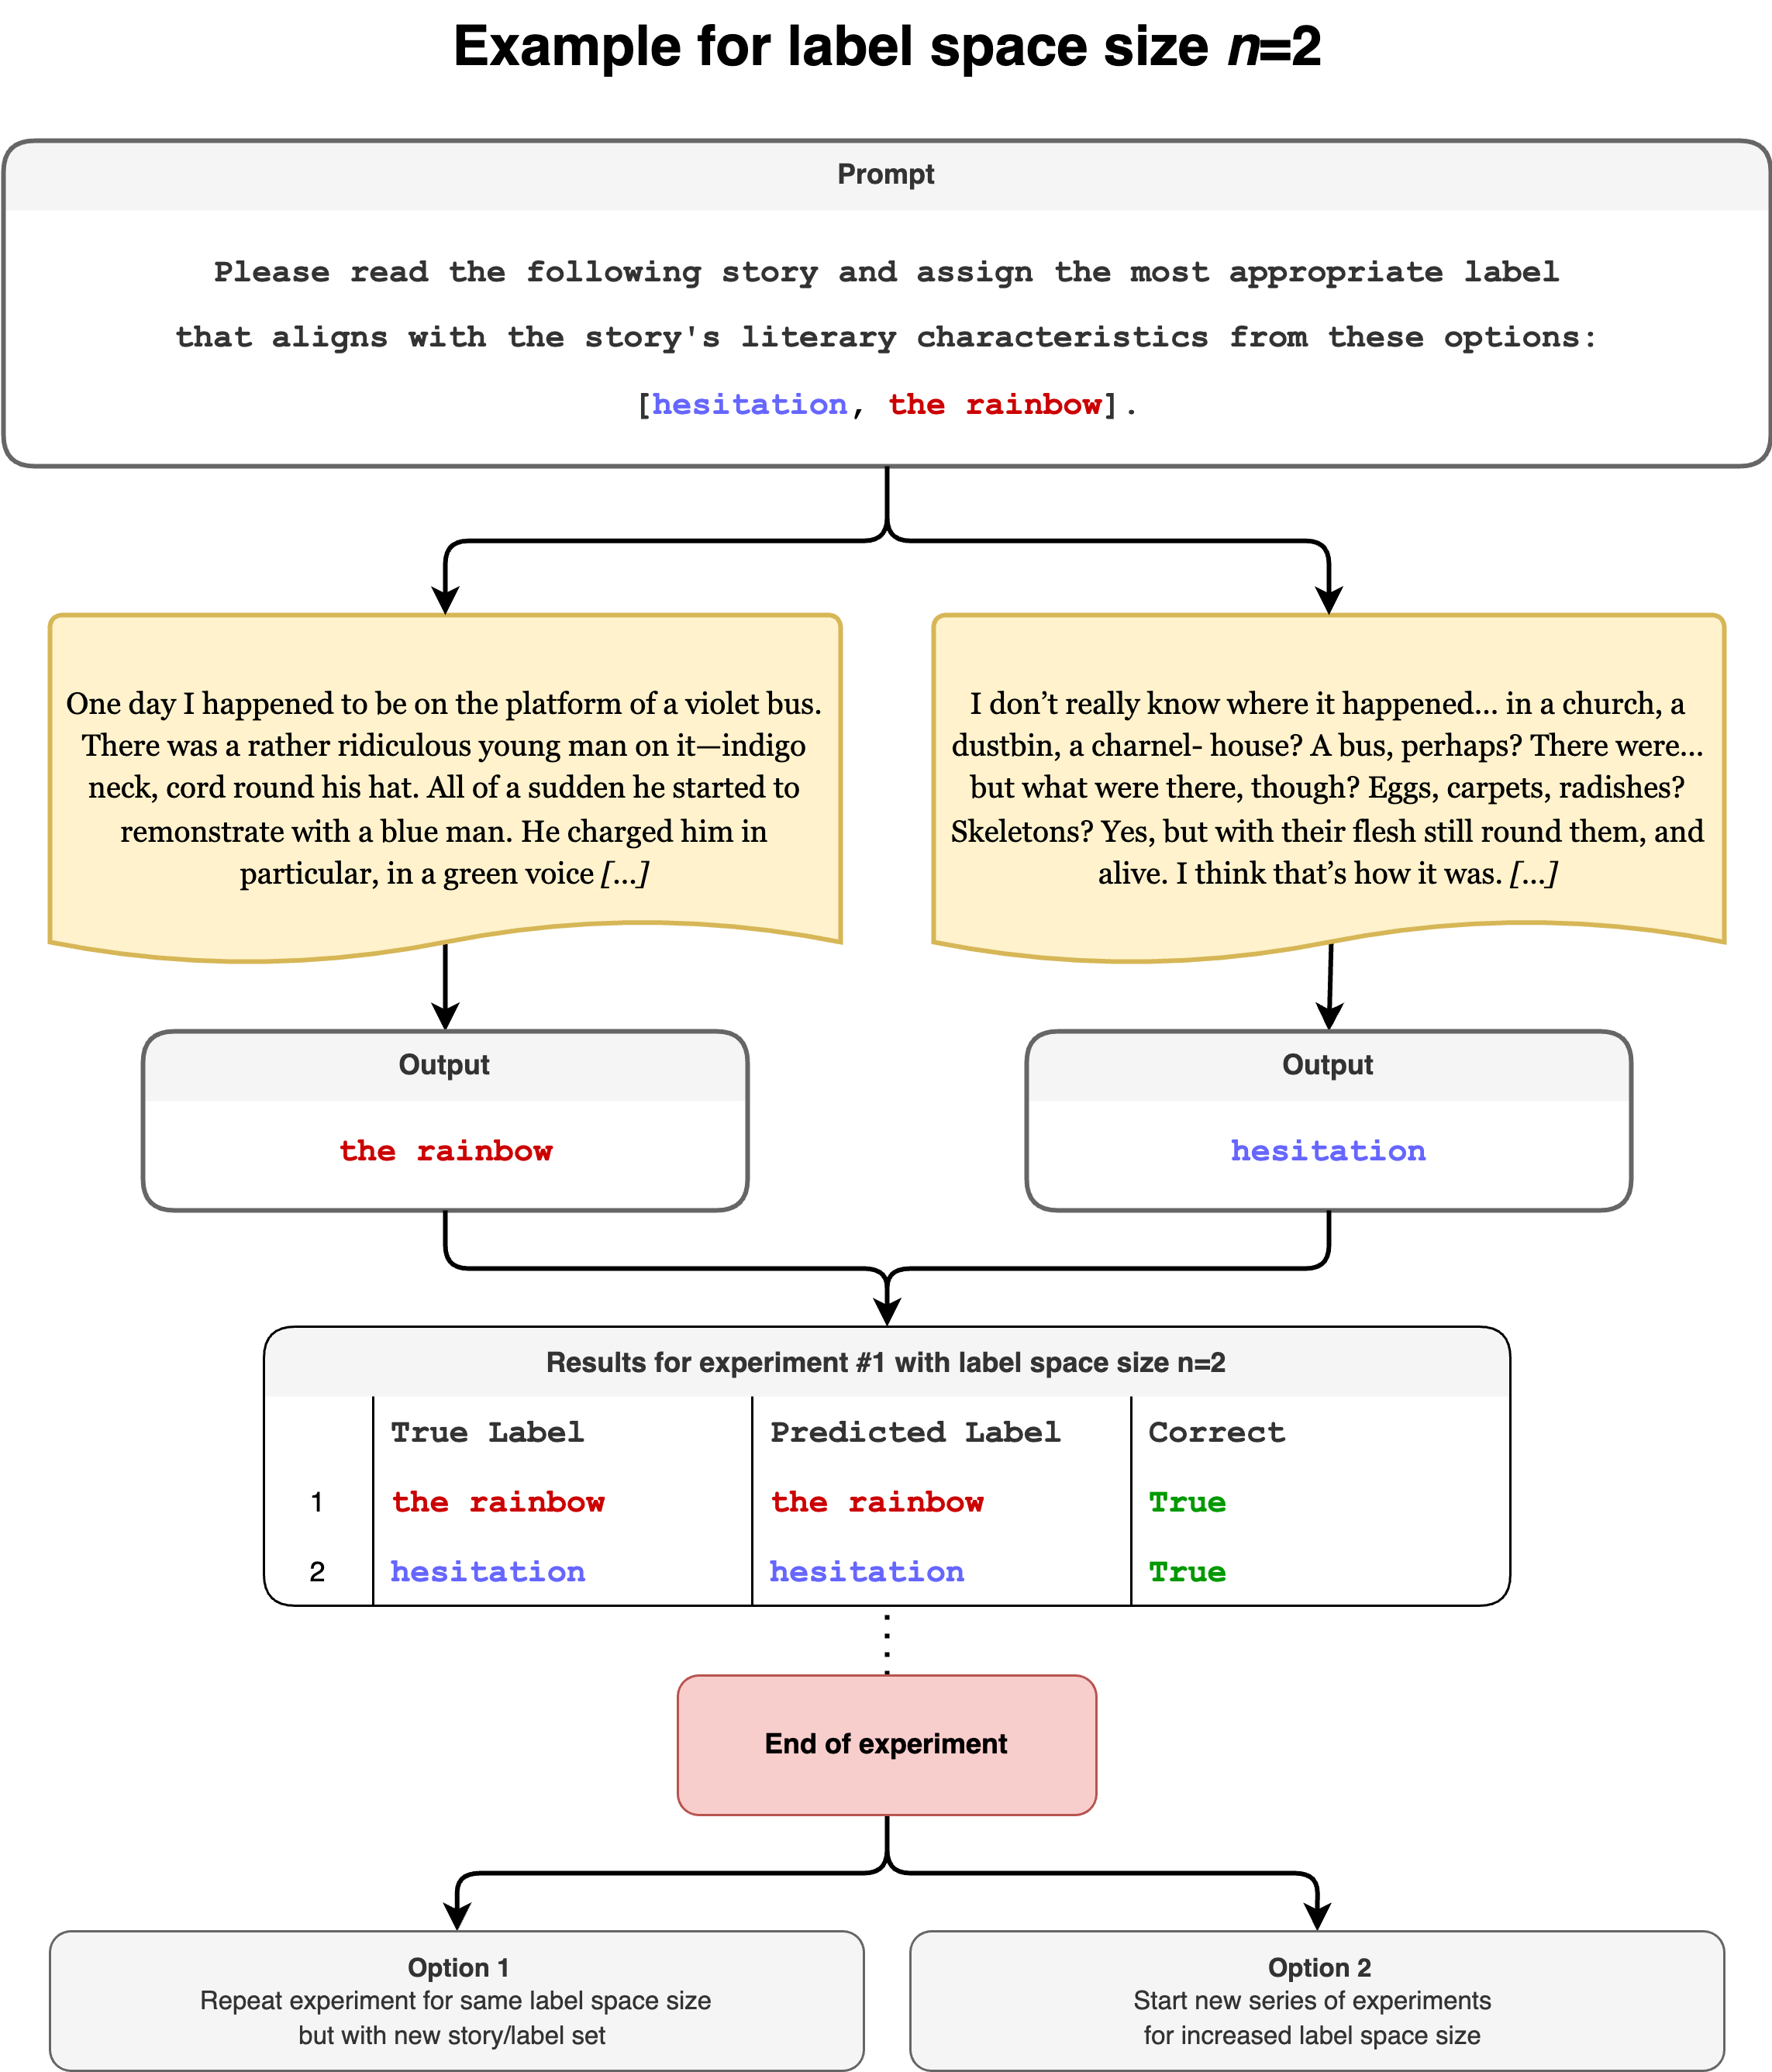

In [5]:
Image(filename="../img/helloqueneau_1.png", width="800")

In [2]:
# get the row with the label notation
df[df['label'] == 'notation']

,id,auth,transl,lang,pubdate,story,label,definition,group
0,1,Raymond Queneau,Barbara Wright,eng,1958,"In the S bus, in the rush hour. A chap of abou...",notation,NaN,NaN


In [391]:
# first, we set the OpenAI API key and load the client
# the key is stored in config.py

import os
import random
import config
import openai
from openai import OpenAI

openai.api_key = config.OPENAI_API_KEY
client = OpenAI(api_key=openai.api_key)

In [392]:
# we set some global parameters for all our experiments
model = "gpt-3.5-turbo-0125" # the model 
temperature = 0.25 # the temperature of the model
num_experiments = 20 # the number of experiments we want to run
min_num_labels = 2 # minimum number of labels we want to run the experiment with (i.e. min label space size)
max_num_labels = 15  # maximum number of labels we want run the experiment with (i.e. max label space size)

In [393]:
# setting the random seed for reproducibility
# make sure that each experiment (both single-story or multi-story) operates on the same set of data!!
# WH--maybe this can still be improved with an increased label space a new label is added to the previous label space
# so, e.g. if the first 2 labels are 'a' and 'b', the first iteration in the next label space will be 'a', 'b', 'c', etc.

RANDOM_SEED = 0  # random seed for reproducibility other seeds
random.seed(RANDOM_SEED)

# generate consistent samples for the experiments
def generate_samples(df, num_labels, num_stories, num_experiments):
    random.seed(RANDOM_SEED)
    samples = []
    filtered_df = df[df['story'].notnull()]  # filter out rows without a story, e.g. "ode" is empty (there is an image fo rit though)
    unique_labels = filtered_df['label'].unique().tolist()
    for _ in range(num_experiments):
        selected_labels = random.sample(unique_labels, k=num_labels)
        # Ensure selected stories correspond to selected labels
        selected_stories = filtered_df[filtered_df['label'].isin(selected_labels)].sample(n=num_stories, random_state=RANDOM_SEED)
        samples.append((selected_stories, selected_labels))
    return samples

In [394]:
# sometimes the outputted label may have extra whitespace or quotes
# so we get rid of them using this little function
def clean_label(label):
    return label.strip().replace("'", "").replace('"', "")

# function to predict the label of a story using a subset of labels
def predict_label(story, labels):
    system_message = f"Please read the following story and assign the most appropriate label that aligns with the story's literary characteristics from these options: {labels}. Respond with only the label name. For example, if the correct label is 'notation', reply 'notation'."
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": story}
        ],
        model=model, 
        max_tokens=60,
        temperature=temperature,
        top_p=1,
        n=1,
        stop=None
    )
    # clean the predicted label before returning
    predicted_label = response.choices[0].message.content.strip()

    # uncomment the following print statements if you want to see what gets passed to the model and what comes out
    #print(f"System Message: {system_message}")
    #print(f"User Message (Story): {story}")
    #print(f"Model Response: {predicted_label}")

    return clean_label(predicted_label)


# function to load stories and predict labels with varying numbers of possible labels
def run_experiment(df, num_labels, num_experiments):
    """Run the prediction experiment with controlled sampling."""
    samples = generate_samples(df, num_labels, num_labels, num_experiments)  # Ensure each experiment has the same story/label setup
    results = []
    experiment_number = 0
    for stories, labels in samples:
        experiment_number += 1
        for idx, row in stories.iterrows():
            predicted_label = predict_label(row['story'], labels)
            results.append({
                'Experiment': experiment_number,
                'Story Index': idx,
                'True Label': row['label'],
                'Predicted Label': predicted_label,
                'Correct': row['label'] == clean_label(predicted_label),
                'Label Space Size': num_labels
            })
    return pd.DataFrame(results)

# run experiments for varying label spaces
all_results = []
print(f"Running experiments with controlled samples...\nWith {num_experiments} experiments each, ranging from {min_num_labels} to {max_num_labels} labels.")
for i in range(min_num_labels, max_num_labels + 1):
    result_df = run_experiment(df, i, num_experiments)
    all_results.append(result_df)
    print(f"Accuracy with {i} labels: {result_df['Correct'].mean():.2f}")
    result_df.to_csv(f'../results/results_onestoryperprompt/results_for_{i}_labels.csv', index=False)

Running experiments with controlled samples...
With 20 experiments each, ranging from 2 to 15 labels.
Accuracy with 2 labels: 0.88
Accuracy with 3 labels: 0.72
Accuracy with 4 labels: 0.71
Accuracy with 5 labels: 0.63
Accuracy with 6 labels: 0.58
Accuracy with 7 labels: 0.59
Accuracy with 8 labels: 0.53
Accuracy with 9 labels: 0.58
Accuracy with 10 labels: 0.51
Accuracy with 11 labels: 0.53
Accuracy with 12 labels: 0.47
Accuracy with 13 labels: 0.46
Accuracy with 14 labels: 0.49
Accuracy with 15 labels: 0.46


Initial results indicate a decline in accuracy as the label space size increases. This is not very surprising, given the increased complexity of the task: larger label spaces prove to be more challenging.

This result becomes visually more clear, when we aggregate results from _all experimental runs_ to assess the overall performance trend. Below, we calculate the mean accuracy and its standard error for each label space size, and use them for confidence interval plotting.

In [395]:
# all_results is a list of dataframes, we concatenate them into one big dataframe
combined_df = pd.concat(all_results, ignore_index=True)
# inspect the tail
combined_df.head(10)

,Experiment,Story Index,True Label,Predicted Label,Correct,Label Space Size
0,1,53,olfactory,olfactory,True,2
1,1,49,awkward,awkward,True,2
2,2,33,polyptotes,polyptotes,True,2
3,2,5,surprises,surprises,True,2
4,3,66,gallicisms,gallicisms,True,2
5,3,63,haiku,haiku,True,2
6,4,51,biased,exclamations,False,2
7,4,38,exclamations,exclamations,True,2
8,5,62,reactionary,reactionary,True,2
9,5,45,parechesis,parechesis,True,2


In [396]:
# a couple of helper functions here, one to calculate the summary statistics, look at label discrepancies, and another to plot the results
# we can use these throughout the notebook to keep things clean!

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def check_label_discrepancies(df):
    true_label_counts = df['True Label'].value_counts().rename('True Count')
    predicted_label_counts = df['Predicted Label'].value_counts().rename('Predicted Count')

    # combine both counts into a single df for comparison
    label_counts = pd.concat([true_label_counts, predicted_label_counts], axis=1, sort=False).fillna(0)
    
    # calculate discrepancies
    label_counts['Discrepancy'] = label_counts['True Count'] - label_counts['Predicted Count']
    
    return label_counts

# calculate mean, standard error of the mean, and conf intervals
def calculate_summary(df):
    # dict where we collect the results
    results = {
        'Label Space Size': [],
        'Mean Accuracy': [],
        'Accuracy SEM': [],
        'Lower CI Accuracy': [],
        'Upper CI Accuracy': [],
        'Mean Precision': [],
        'Mean Recall': [],
        'Mean F1 Score': []
    }

    # group the data by label space size
    for label_size, group in df.groupby('Label Space Size'):
        y_true = group['True Label'].tolist()
        y_pred = group['Predicted Label'].tolist()

        # calculate acc, precision, recall, f1
        accuracy = accuracy_score(y_true, y_pred)
        precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
        
        # also calculate SEM for confidence intervals used in ploitting
        accuracies = [accuracy_score(subgroup['True Label'], subgroup['Predicted Label'])
                      for _, subgroup in group.groupby('Experiment')]
        accuracy_sem = pd.Series(accuracies).sem()

        # aggregate data
        results['Label Space Size'].append(label_size)
        results['Mean Accuracy'].append(accuracy)
        results['Accuracy SEM'].append(accuracy_sem)
        results['Lower CI Accuracy'].append(accuracy - 1.96 * accuracy_sem)
        results['Upper CI Accuracy'].append(accuracy + 1.96 * accuracy_sem)
        results['Mean Precision'].append(precision)
        results['Mean Recall'].append(recall)
        results['Mean F1 Score'].append(f1_score)

    return pd.DataFrame(results)

# plot the results
def plot_results(summary_df, title, summary_df_multi_story=None):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(10, 6))

    # plot single-story or primary results
    sns.lineplot(data=summary_df, x='Label Space Size', y='Mean Accuracy', marker='o', label='Single story prompt, mean accuracy', color='skyblue')
    plt.fill_between(summary_df['Label Space Size'], summary_df['Lower CI Accuracy'], summary_df['Upper CI Accuracy'], color='skyblue', alpha=0.3)

    # plot multi-story results IF provided
    if summary_df_multi_story is not None:
        sns.lineplot(data=summary_df_multi_story, x='Label Space Size', y='Mean Accuracy', marker='o', label='Multi story prompt, mean accuracy', color='orange')
        plt.fill_between(summary_df_multi_story['Label Space Size'], summary_df_multi_story['Lower CI Accuracy'], summary_df_multi_story['Upper CI Accuracy'], color='orange', alpha=0.3)

    plt.title(title, fontsize=14)
    plt.xlabel('Number of labels', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xticks(summary_df['Label Space Size'], labels=summary_df['Label Space Size'].unique(), fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [397]:
# look at major discrepancies
label_discrepancies = check_label_discrepancies(combined_df)
label_discrepancies.sort_values(by='Discrepancy', ascending=False)

,True Count,Predicted Count,Discrepancy
precious,47.0,1.0,46.0
futile,38.0,1.0,37.0
insistence,37.0,1.0,36.0
noble,37.0,3.0,34.0
more or less,42.0,9.0,33.0
...,...,...,...
reported speech,38.0,113.0,-75.0
synchysis,29.0,107.0,-78.0
gallicisms,30.0,113.0,-83.0
narrative,32.0,124.0,-92.0


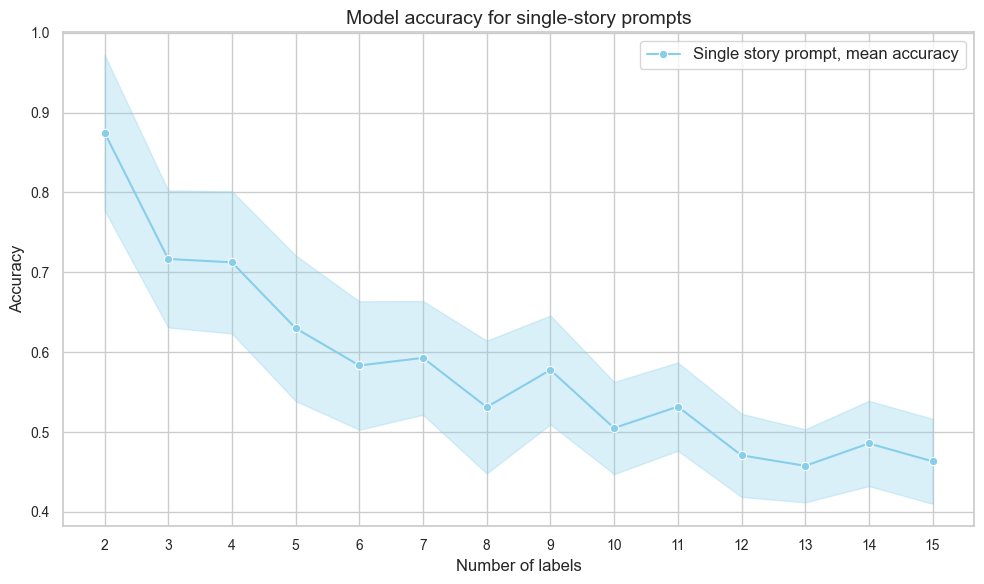

,Label Space Size,Mean Accuracy,Accuracy SEM,Lower CI Accuracy,Upper CI Accuracy,Mean Precision,Mean Recall,Mean F1 Score
0,2,0.875000,0.049670,0.777647,0.972353,0.821429,0.871429,0.834014
1,3,0.716667,0.043763,0.630891,0.802442,0.627660,0.737589,0.660284
2,4,0.712500,0.045433,0.623452,0.801548,0.614943,0.696839,0.628654
3,5,0.630000,0.046510,0.538841,0.721159,0.503571,0.618490,0.538632
4,6,0.583333,0.041003,0.502966,0.663700,0.501911,0.578638,0.509741
5,7,0.592857,0.036311,0.521688,0.664026,0.511530,0.600457,0.523205
6,8,0.531250,0.042414,0.448119,0.614381,0.456571,0.515171,0.451105
7,9,0.577778,0.034765,0.509639,0.645916,0.547422,0.572708,0.533456
8,10,0.505000,0.029447,0.447285,0.562715,0.439986,0.510976,0.443894
9,11,0.531818,0.028194,0.476558,0.587079,0.503694,0.541473,0.484469


In [398]:
# summary statistics
summary_df = calculate_summary(combined_df)

# plot for single story prompts
plot_results(summary_df, 'Model accuracy for single-story prompts')
summary_df

Now, how accurately does the model actually distinguish between different narrative styles? The confusion matrix below visualizes the frequency at which specific stories are misclassified as other stories.

In [399]:
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import normalize

# maximum label space size in df_combined
#max_label_space_size = combined_df['Label Space Size'].max()

# we can also set this manually! (for large label spaces, it might be better to set this manually)
max_label_space_size = 2
df_filtered = combined_df[combined_df['Label Space Size'] == max_label_space_size]

# generate confusion matrix
labels = sorted(df_filtered['True Label'].unique())
cm = confusion_matrix(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# normalize the confusion matrix
cm_normalized = normalize(cm, norm='l1', axis=1)  # normalize by rows (true labels)

# calculate precision and recall
precision, recall, _, _ = precision_recall_fscore_support(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# we fill the tooltip
hover_text = [
    [
        f"Correct story label: {labels[i]}<br>"
        f"Recognized as '{labels[j]}'<br>"
        f"Count: {cm[i, j]} times out of {np.sum(cm[i, :])}<br>"
        f"Ratio: {cm_normalized[i, j]:.2f}<br>"
        for j in range(len(labels))
    ]
    for i in range(len(labels))
]

# plot
fig = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=labels,
    y=labels,
    annotation_text=np.round(cm_normalized, 2).astype(str),
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title=f'Normalized Confusion Matrix for Label Space Size {max_label_space_size}',
    xaxis_title='Predicted Labels',
    yaxis_title='True Labels',
    xaxis={'side': 'bottom'},
    yaxis=dict(autorange='reversed'),
    width=900,
    height=900,
    font=dict(size=9),
    margin=dict(t=50, l=50)
)
fig.update_traces(hoverinfo='text', text=hover_text)
fig.show()

/Users/wouter/anaconda3/envs/helloqueneau/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<img src="../img/conf-exp1.png"/>

Some observations and questions to consider:

- The matrix shows that when `narrative` is part of the label set, the model shows a strong inclination towards it. This result makes sense: it is a very safe guess for the model, given that essentially all stories can be considered 'narratives'. In other wors, it is likely that the confusion is due to the model's tendency to prioritize more general labels over specific or unique ones.
  
- The same confusion does not seem to occur, however, for the label `notation`, which - I would say - is very similar to `narrative`.

- A considerable number of stories are being incorrectly labeled as `synchysis`. Given that synchysis involves a scattered or disordered arrangement of words (it literally means ["confusion" or "commixtion"](https://babel.hathitrust.org/cgi/pt?id=nyp.33433069255184&view=1up&seq=830&q1=synchysis)), this frequent misrecognition might indicate the model's sensitivity to any syntactic or semantic irregularities in the text. Could it be that the LLM is overly attentive to unusual word patterns, interpreting them as intentional artistic devices rather than regular narrative flow?

- The confusion surrounding the `synchysis` label is also interesting on a meta-level. LLMs, by design, manipulate and recombine vast amounts of textual data based on learned patterns from their training corpus. Could we argue that an LLMs task of generating text resembles a sort of controlled synchysis where words and phrases are rearranged? In essence, LLMs continuously perform a task similar to synchysis but aim for coherence and order. (This reflection might be a stretch :-))


## Experiment #2

As we've seen in the previous experiment, when the label space increases, the model's task becomes more challenging leading to more errors and lower precision for specific labels. This complexity underscores the difficulty in fine-grained stylistic differentiation without additional contextual information or more nuanced understanding of the text content by the model.

Observing the model's performance in predicting individual labels independently raises an interesting hypothesis about the potential benefits of providing the model with _all stories and corresponding labels at once_. This setup could reduce confusion by allowing the model to use the context of other stories to better understand the unique stylistic elements of each story. 

For example, if the model could compare and contrast the themes and styles of all stories simultaneously, it might more effectively discern the specific characteristics that define each label.

In this experiment, we will present the model with all stories and their corresponding labels at once. The model will then be asked to predict the correct label for each story. This new setup tests whether contextual relationships between stories when viewed together aid the model's performance -- and here too, as the number of stories (and therefore complexity) increases.

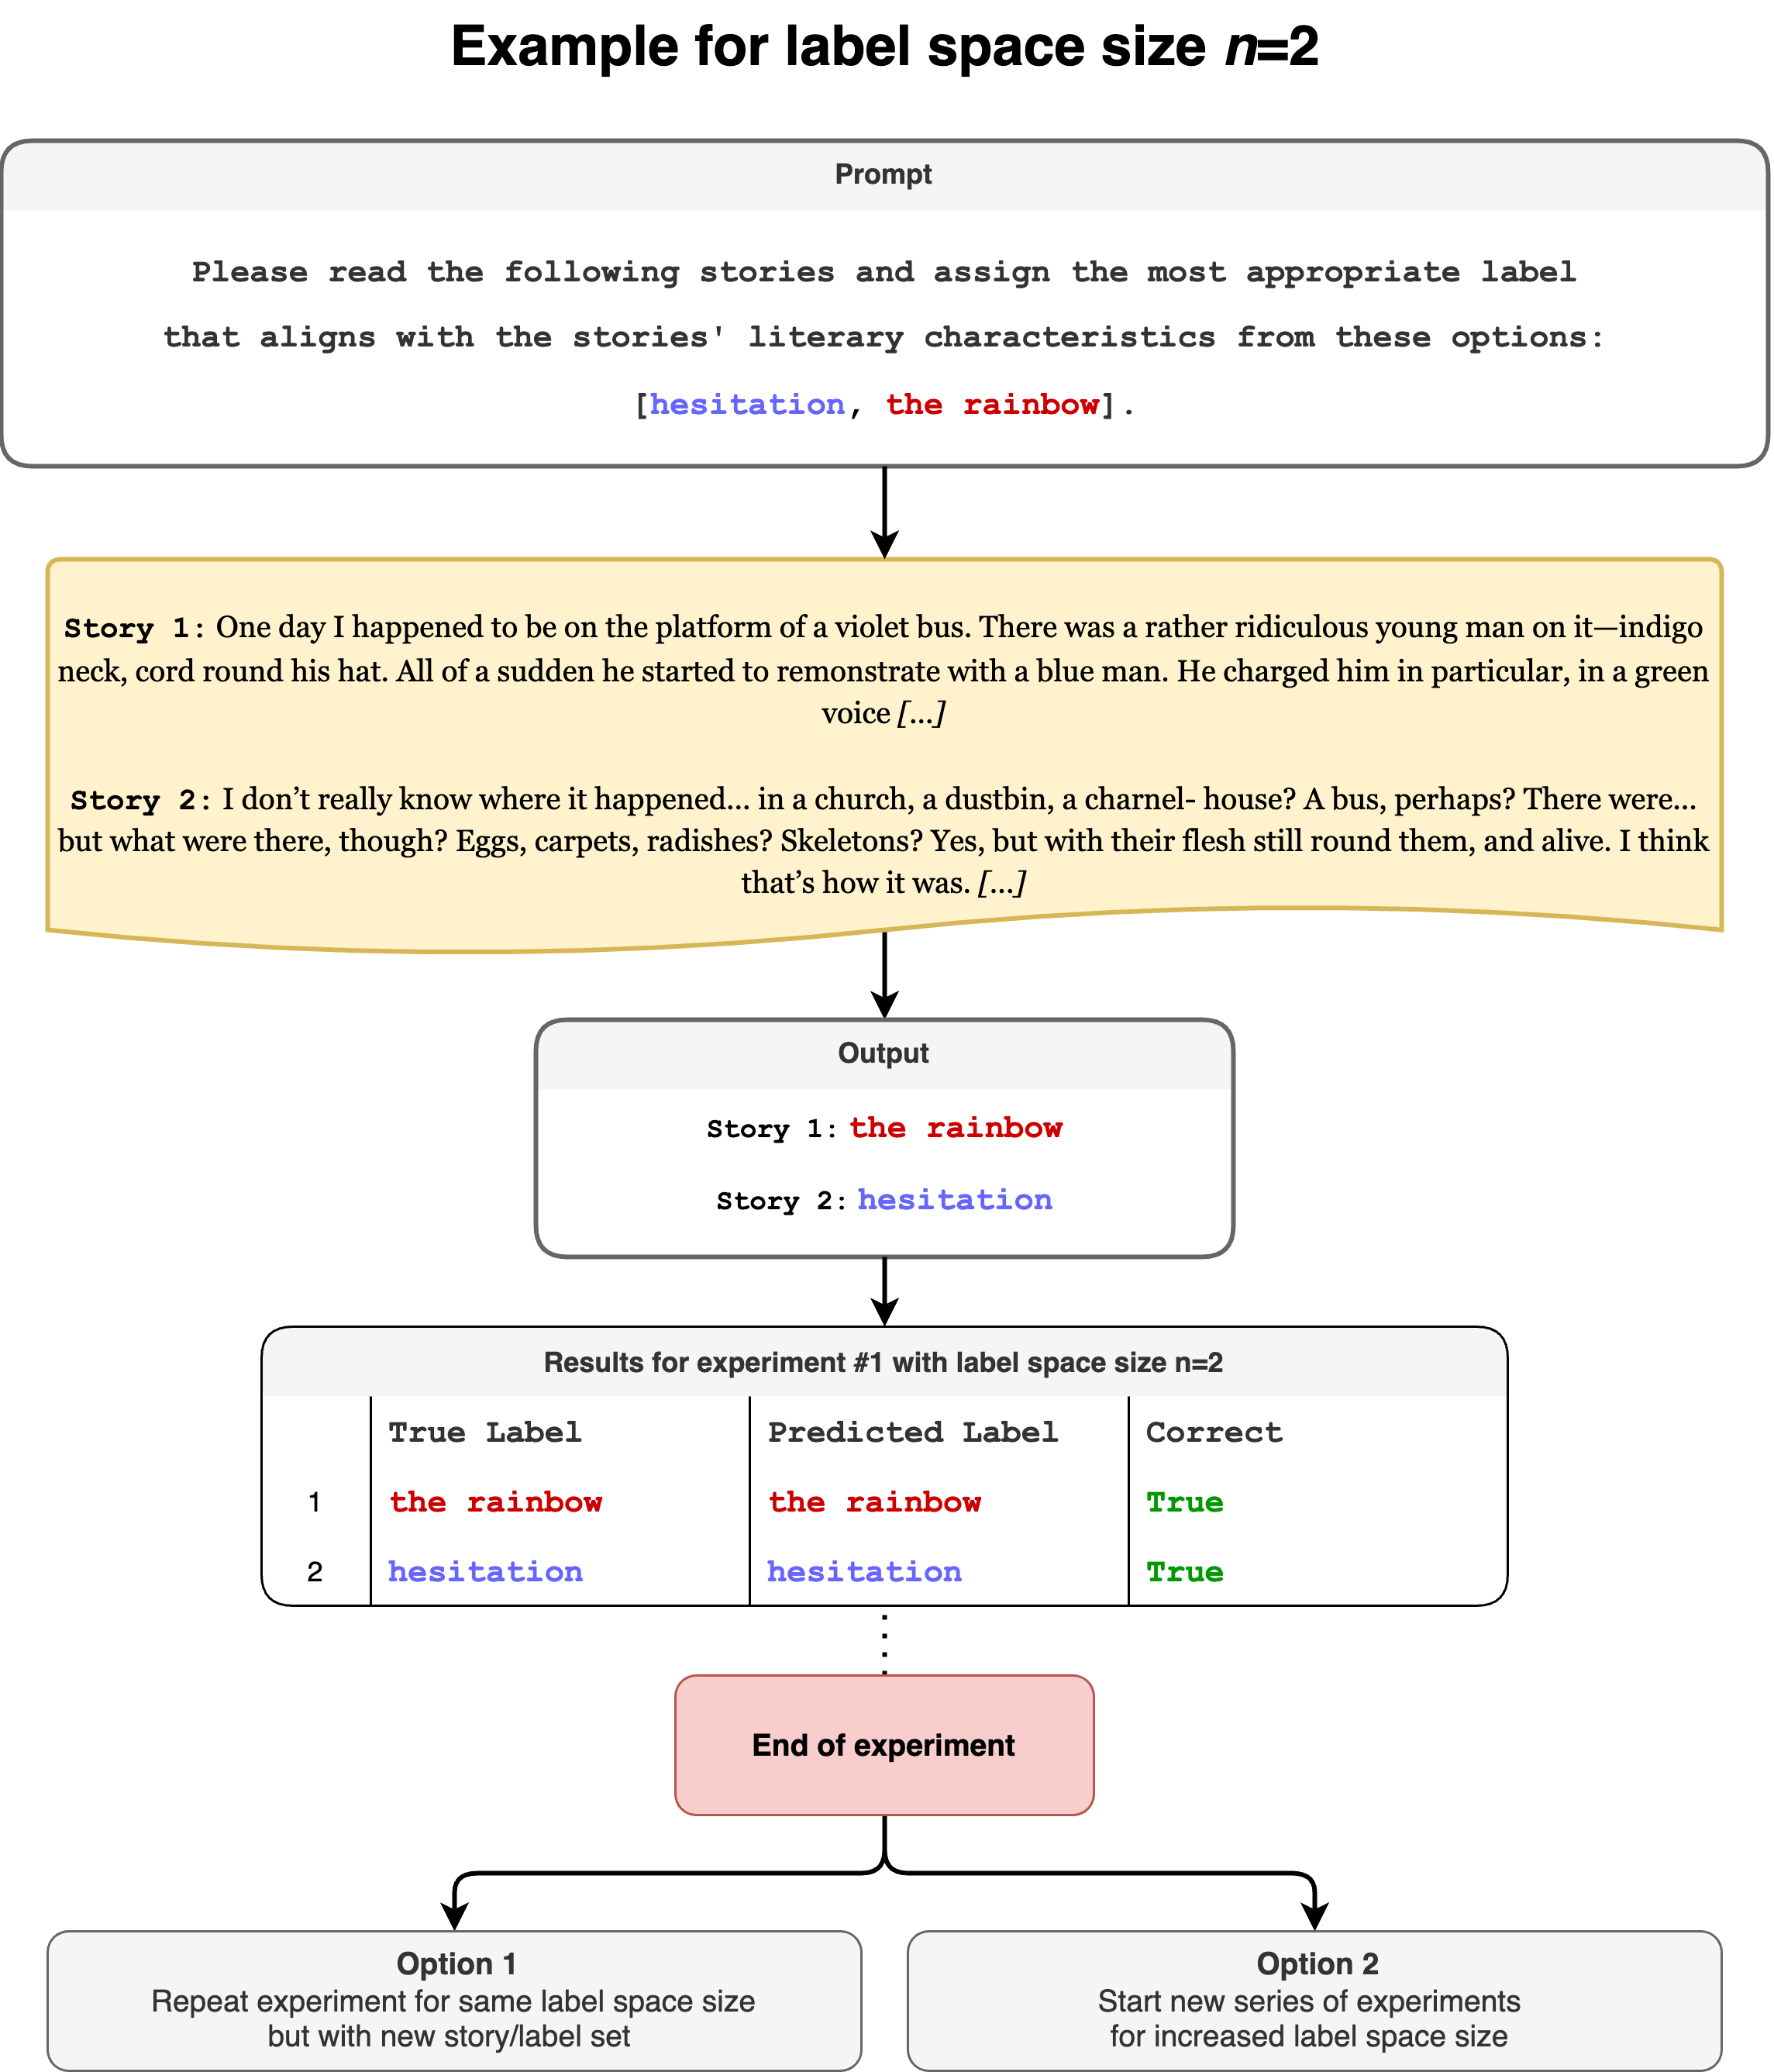

In [8]:
Image(filename="../img/helloqueneau_2.png", width="800")

In [400]:
def predict_labels_multi_story(stories, labels):
    
    #random.shuffle(labels)  # shuffle labels so they're not (necessarily) in the same order as the stories -- necessary?
    
    # system message combining all stories
    system_message = (
        "Please read the following stories and assign the most appropriate label that aligns with the stories literary features from these options: "
        f"{labels}. You must respond with a label for each story in the order they appear. For example, if the correct label for story 1 is 'notation', reply '1: notation'; continue this pattern for each story. Each label can only be assigned once."
    )
    stories_message = "\n".join([f"Story {i+1}: {story}" for i, story in enumerate(stories)])
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": stories_message}
        ],
        model=model, 
        max_tokens=60,
        temperature=temperature,
        top_p=1,
        n=1,
        stop=None
    )
    
    #print(f"System Message: {system_message}")
    #print(f"User Message (Stories): {stories_message}")
    #print(f"Model Response: {response.choices[0].message.content.strip()}")

    # process predicted labels, get the part after the colon
    predicted_labels = response.choices[0].message.content.strip().split("\n")
    clean_predicted_labels = []
    for i, label_info in enumerate(predicted_labels):
        label = label_info.split(': ')[-1].strip() if ':' in label_info else "UNASSIGNED"
        clean_predicted_labels.append(label)

    return clean_predicted_labels

def process_stories_multi_story(samples):
    predictions = []
    experiment_number = 0
    for stories, labels in samples:
        experiment_number += 1
        predicted_labels = predict_labels_multi_story(stories['story'].tolist(), labels)
        for idx, (predicted_label, story) in enumerate(zip(predicted_labels, stories.iterrows())):
            story_data = story[1]
            predictions.append({
                'Experiment': experiment_number,
                'Story Index': story[0],
                'True Label': story_data['label'],
                'Predicted Label': predicted_label,
                'Correct': story_data['label'] == clean_label(predicted_label),
                'Label Space Size': len(labels)
            })
    return pd.DataFrame(predictions)

# using same samples generated for the first experiment
all_results_multi_story = []
print(f"Running multi-story experiments...\nWith {num_experiments} experiments each, ranging from {min_num_labels} to {max_num_labels} stories.")
for i in range(min_num_labels, max_num_labels + 1):
    results = process_stories_multi_story(generate_samples(df, i, i, num_experiments))
    result_df = pd.DataFrame(results)
    all_results_multi_story.append(result_df)
    print(f"Accuracy with {i} stories: {result_df['Correct'].mean():.2f}")
    result_df.to_csv(f'../results/results_multistoryprompt/results_for_{i}_stories_multi_story.csv', index=False)

Running multi-story experiments...
With 20 experiments each, ranging from 2 to 15 stories.
Accuracy with 2 stories: 0.95
Accuracy with 3 stories: 0.81
Accuracy with 4 stories: 0.75
Accuracy with 5 stories: 0.57
Accuracy with 6 stories: 0.63
Accuracy with 7 stories: 0.58
Accuracy with 8 stories: 0.54
Accuracy with 9 stories: 0.49
Accuracy with 10 stories: 0.55
Accuracy with 11 stories: 0.49
Accuracy with 12 stories: 0.39
Accuracy with 13 stories: 0.51
Accuracy with 14 stories: 0.41
Accuracy with 15 stories: 0.37


In [401]:
# all_results is still a list of dfs, we concatenate them into one big df
combined_df_multi_story = pd.concat(all_results_multi_story, ignore_index=True)
# inspect the tail
combined_df_multi_story.head()

,Experiment,Story Index,True Label,Predicted Label,Correct,Label Space Size
0,1,53,olfactory,olfactory,True,2
1,1,49,awkward,awkward,True,2
2,2,33,polyptotes,polyptotes,True,2
3,2,5,surprises,surprises,True,2
4,3,66,gallicisms,gallicisms,True,2


In [402]:
# look at major discrepancies for multi-story prompts
label_discrepancies_multi = check_label_discrepancies(combined_df_multi_story)
label_discrepancies_multi.sort_values(by='Discrepancy', ascending=False)

,True Count,Predicted Count,Discrepancy
prognostication,37.0,27,10.0
past,31.0,24,7.0
word game,36.0,29,7.0
antiphrasis,30.0,24,6.0
the rainbow,25.0,20,5.0
...,...,...,...
13:,0.0,5,-5.0
narrative,30.0,35,-5.0
haiku,33.0,38,-5.0
UNASSIGNED,0.0,9,-9.0


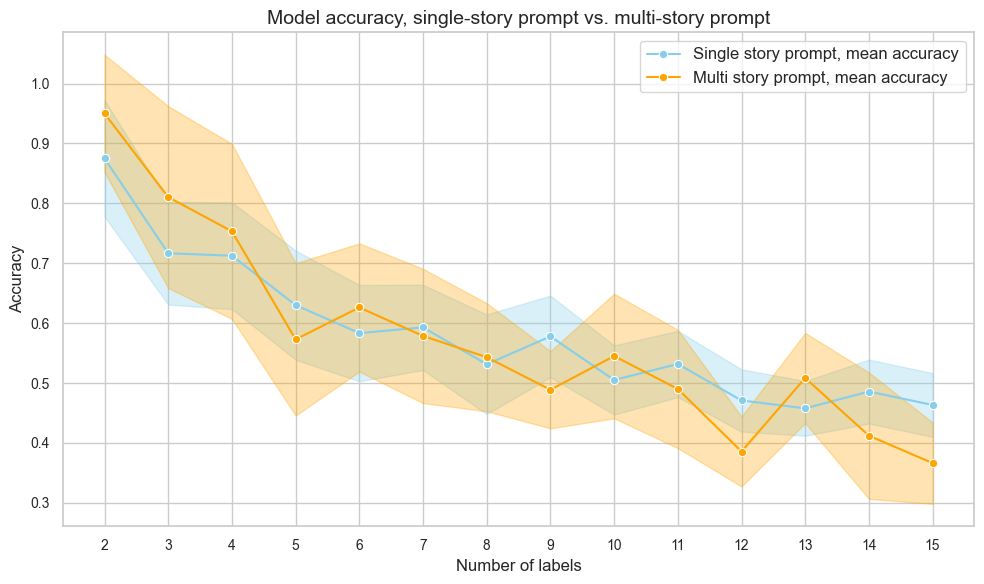

In [403]:
summary_df_multi_story = calculate_summary(combined_df_multi_story)

# plot the combined results
plot_results(summary_df, 'Model accuracy, single-story prompt vs. multi-story prompt', summary_df_multi_story)
#summary_df_multi_story

In [340]:
import numpy as np
import plotly.figure_factory as ff
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import normalize

# maximum label space size in df_combined
#max_label_space_size = combined_df_multi_story['Label Space Size'].max()

# we can also set this manually! (for large label spaces, it might be better to set this manually)
max_label_space_size = 3
df_filtered = combined_df_multi_story[combined_df_multi_story['Label Space Size'] == max_label_space_size]

# generate confusion matrix
labels = sorted(df_filtered['True Label'].unique())
cm = confusion_matrix(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# normalize the confusion matrix
cm_normalized = normalize(cm, norm='l1', axis=1)  # normalize by rows (true labels)

# calculate precision and recall
precision, recall, _, _ = precision_recall_fscore_support(df_filtered['True Label'], df_filtered['Predicted Label'], labels=labels)

# we fill the tooltip
hover_text = [
    [
        f"Correct story label: {labels[i]}<br>"
        f"Recognized as '{labels[j]}'<br>"
        f"Count: {cm[i, j]} times out of {np.sum(cm[i, :])}<br>"
        f"Ratio: {cm_normalized[i, j]:.2f}<br>"
        for j in range(len(labels))
    ]
    for i in range(len(labels))
]

# plot
fig = ff.create_annotated_heatmap(
    z=cm_normalized,
    x=labels,
    y=labels,
    annotation_text=np.round(cm_normalized, 2).astype(str),
    colorscale='Blues',
    showscale=True
)
fig.update_layout(
    title=f'Normalized Confusion Matrix for Label Space Size {max_label_space_size}',
    xaxis_title='Predicted Labels',
    yaxis_title='True Labels',
    xaxis={'side': 'bottom'},
    yaxis=dict(autorange='reversed'),
    width=900,
    height=900,
    font=dict(size=9),
    margin=dict(t=50, l=50)
)
fig.update_traces(hoverinfo='text', text=hover_text)
fig.show()

<img src="../img/conf-exp2.png"/>

## Experiment 3
Prompt LLM to come up with own labels

In the experiment below, we take on an entirely new approach! Instead of asking the model to choose from "predefined" labels (i.e. Queneau's titles), we make it generate its own. Afterward, we get the word embeddings for the original, authentic Queneau-label and the model's self-assigned label. Finally, we calculate the cosine similarity between these embeddings to determine how close the model's label is to the original one. Broken down, the experiment looks like this:

1. For each story, we provide an example story with a known style to the `GPT-3.5-turbo-0125 model`. The model reads an alternative version of the story (authored by Queneau) and generates a one-word label that best describes its tone or style.

2. Using the BERT, we calculate the word embeddings for both the original label (true label) and the self-assigned label (predicted label).

3. We calculate the cosine similarity between the BERT embeddings of the true and predicted labels. And eventually show the results in a scatter plot.

In [69]:
df_sample = df.sample(50)

In [89]:
# WH - not sure if this is the most efficient way to do this
# doing the experiment n times is not as useful here, because  alot of the labels will be the same. 
# maybe prompt the model to come up with 5 different labels for the same story and then compare them to the true label? 

from transformers import BertModel, BertTokenizer
from scipy.spatial.distance import cosine
from tqdm import tqdm

# load BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# get BERT embedding of a label
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = bert_model(**inputs)
    # use the last hidden state as the word embedding
    embedding = outputs.last_hidden_state[0, 0].detach().numpy()
    return embedding

# predict the label of a story
def predict_labels(story, sample_story, sample_label, model="gpt-3.5-turbo-0125", temperature=0.2):
    # old prompt -- system_message = f"There is a story that has been rewritten into numerous different styles. This is an example of that story written in the style '{sample_label}': '{sample_story}'. Now, I want you to read an alternative version that has undergone style transfer and come up with five accurate, one-word labels that best describe its tone or style. Here is the story: '{story}'. Respond with only the label names, separated by commas."
    system_message = f"There is a story that has been rewritten in numerous different ways. This is an example of that story written in the style '{sample_label}': '{sample_story}'. Now, I want you to read an alternative version that has undergone changes in style, point of view, genre, or other literary aspects. Please come up with five accurate, one-word labels that best describe its tone, style, or any notable literary characteristic. Here is the story: '{story}'. Respond with only the label names, separated by commas."
    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": story}
        ],
        model=model,
        max_tokens=150,
        temperature=temperature,
        top_p=1,
        n=1,
        stop=None
    )
    # print the prompt and the output
    #print("Prompt:\n", system_message)
    #print("Output:\n", response.choices[0].message.content)
    
    # clean and split the predicted labels before returning
    predicted_labels = [clean_label(label) for label in response.choices[0].message.content.strip().split(",")]
    return predicted_labels

# function to calculate the similarity between two words using BERT embeddings
def calculate_similarity(word1, word2):
    embedding1 = get_bert_embedding(word1)
    embedding2 = get_bert_embedding(word2)
    return 1 - cosine(embedding1, embedding2)

# function to load stories and predict labels
def process_stories(df, num_experiments=10):
    predictions = []
    pbar = tqdm(total=df.shape[0], desc="Processing stories")
    for idx, row in df.iterrows():
        if pd.isna(row['story']):
            print(f"\nSkipping story {idx+1}/{df.shape[0]} due to NaN value.")
            continue

        print(f"\nProcessing story {idx+1}/{df.shape[0]} with label: '{row['label']}'")
        
        # get a unique sample story for this experiment
        sample_indices = random.sample(list(set(df.index) - {idx}), num_experiments)
        
        for experiment in range(num_experiments):
            # get a sample story and its label
            sample_idx = sample_indices[experiment]
            sample_story = df.loc[sample_idx, 'story']
            sample_label = df.loc[sample_idx, 'label']

            if pd.isna(sample_story):
                print(f"\tSkipping sample story {sample_idx+1}/{df.shape[0]} due to NaN value.")
                continue
            
            try:
                predicted_labels = predict_labels(row['story'], sample_story, sample_label, model="gpt-4o", temperature=temperature)
                
                # calculate similarity for each predicted label
                for predicted_label in predicted_labels:
                    similarity = calculate_similarity(row['label'], predicted_label)
                    print(f"\tExperiment {experiment+1}/{num_experiments}:")
                    print(f"\t\tExample story {sample_idx+1}/{df.shape[0]} label: '{sample_label}'")
                    print(f"\t\tSuggested label '{predicted_label}'")
                    predictions.append({
                        'Experiment': experiment + 1,
                        'Story Index': idx,
                        'True Label': row['label'],
                        'Predicted Label': predicted_label,
                        'Similarity': similarity,
                        'Sample Label': sample_label
                    })
            except Exception as e:
                print(f"\tError processing story {idx+1} with sample story {sample_idx+1}: {e}")
        pbar.update(1)
    pbar.close()
    return predictions

# run experiments
results = process_stories(df_sample, num_experiments=1)
results_df = pd.DataFrame(results)
results_df.to_csv('../results/results_onewordlabel/results.csv', index=False)


Processing story 64/50 with label: 'haiku'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Minimalist'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Fragmented'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Abstract'


	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Poetic'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Experimental'

Processing story 5/50 with label: 'retrograde'
	Experiment 1/1:
		Example story 45/50 label: 'asides'
		Suggested label 'Narrative'
	Experiment 1/1:
		Example story 45/50 label: 'asides'
		Suggested label 'Observational'
	Experiment 1/1:
		Example story 45/50 label: 'asides'
		Suggested label 'Descriptive'


	Experiment 1/1:
		Example story 45/50 label: 'asides'
		Suggested label 'Third-person'
	Experiment 1/1:
		Example story 45/50 label: 'asides'
		Suggested label 'Concise'

Processing story 80/50 with label: 'opera English'
	Experiment 1/1:
		Example story 16/50 label: 'narrative'
		Suggested label 'Operatic'
	Experiment 1/1:
		Example story 16/50 label: 'narrative'
		Suggested label 'Dramatic'
	Experiment 1/1:
		Example story 16/50 label: 'narrative'
		Suggested label 'Satirical'


	Experiment 1/1:
		Example story 16/50 label: 'narrative'
		Suggested label 'Theatrical'
	Experiment 1/1:
		Example story 16/50 label: 'narrative'
		Suggested label 'Poetic'

Processing story 26/50 with label: 'logical analysis'
	Experiment 1/1:
		Example story 39/50 label: 'exclamations'
		Suggested label 'Minimalist'
	Experiment 1/1:
		Example story 39/50 label: 'exclamations'
		Suggested label 'Objective'
	Experiment 1/1:
		Example story 39/50 label: 'exclamations'
		Suggested label 'Fragmented'


	Experiment 1/1:
		Example story 39/50 label: 'exclamations'
		Suggested label 'Observational'
	Experiment 1/1:
		Example story 39/50 label: 'exclamations'
		Suggested label 'Analytical'

Processing story 6/50 with label: 'surprises'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Narrative'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Judgmental'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Observational'


	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Exclamatory'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Anecdotal'

Processing story 94/50 with label: 'interjections'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Absurd'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Minimalist'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Experimental'


	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Nonverbal'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Playful'

Processing story 22/50 with label: 'omeoptotes'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Rhythmic'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Alliterative'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Playful'


	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Poetic'
	Experiment 1/1:
		Example story 66/50 label: 'feminine'
		Suggested label 'Whimsical.'

Processing story 24/50 with label: 'blurb'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Elegant'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Narrative'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Descriptive'


	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Literary'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Classic.'

Processing story 20/50 with label: 'anagrams'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'Nonsensical'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'Playful'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'Experimental'


	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'Surreal'

Processing story 79/50 with label: 'more or less'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Playful'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Experimental'


	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Absurd'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Phonetic.'

Processing story 29/50 with label: 'past'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Observational'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Prosaic'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Realistic'


	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Detached'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Narrative'

Processing story 48/50 with label: 'philosophic'
	Experiment 1/1:
		Example story 22/50 label: 'omeoptotes'
		Suggested label 'Philosophical'
	Experiment 1/1:
		Example story 22/50 label: 'omeoptotes'
		Suggested label 'Abstract'
	Experiment 1/1:
		Example story 22/50 label: 'omeoptotes'
		Suggested label 'Dense'


	Experiment 1/1:
		Example story 22/50 label: 'omeoptotes'
		Suggested label 'Esoteric'
	Experiment 1/1:
		Example story 22/50 label: 'omeoptotes'
		Suggested label 'Intellectual'

Processing story 43/50 with label: 'cross-examination'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'interrogative'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'clinical'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'detached'


	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'formal'
	Experiment 1/1:
		Example story 95/50 label: 'precious'
		Suggested label 'procedural'

Processing story 91/50 with label: 'portrait'
	Experiment 1/1:
		Example story 20/50 label: 'anagrams'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 20/50 label: 'anagrams'
		Suggested label 'Descriptive'
	Experiment 1/1:
		Example story 20/50 label: 'anagrams'
		Suggested label 'Satirical'
	Experiment 1/1:
		Example story 20/50 label: 'anagrams'
		Suggested label 'Zoological'


	Experiment 1/1:
		Example story 20/50 label: 'anagrams'
		Suggested label 'Inventive'

Processing story 66/50 with label: 'feminine'
	Experiment 1/1:
		Example story 68/50 label: 'prosthesis'
		Suggested label 'Chatty'
	Experiment 1/1:
		Example story 68/50 label: 'prosthesis'
		Suggested label 'Humorous'


	Experiment 1/1:
		Example story 68/50 label: 'prosthesis'
		Suggested label 'Observational'
	Experiment 1/1:
		Example story 68/50 label: 'prosthesis'
		Suggested label 'Judgmental'
	Experiment 1/1:
		Example story 68/50 label: 'prosthesis'
		Suggested label 'Conversational'

Processing story 37/50 with label: 'syncope'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Abstract'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Experimental'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Fragmented'


	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 61/50 label: 'O'
		Suggested label 'Modernist'

Processing story 44/50 with label: 'comedy'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Theatrical'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Dialogic'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Satirical'


	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Dramatic'
	Experiment 1/1:
		Example story 75/50 label: 'rhyming slang'
		Suggested label 'Prosaic'

Processing story 69/50 with label: 'epenthesis'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Experimental'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Absurd'


	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Phonetic'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Playful'

Processing story 28/50 with label: 'ignorance'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Casual'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Conversational'


	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Realistic'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Subjective'

Processing story 16/50 with label: 'narrative'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Observational'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Narrative'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Descriptive'


	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Realistic'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Anecdotal'

Processing story 61/50 with label: 'O'
	Experiment 1/1:
		Example story 43/50 label: 'cross-examination'
		Suggested label 'Playful'
	Experiment 1/1:
		Example story 43/50 label: 'cross-examination'
		Suggested label 'Rhythmic'
	Experiment 1/1:
		Example story 43/50 label: 'cross-examination'
		Suggested label 'Poetic'


	Experiment 1/1:
		Example story 43/50 label: 'cross-examination'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 43/50 label: 'cross-examination'
		Suggested label 'Experimental'

Processing story 35/50 with label: 'apheresis'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Fragmented'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Experimental'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Abstract'


	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Minimalist'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Cryptic'

Processing story 67/50 with label: 'gallicisms'
	Experiment 1/1:
		Example story 29/50 label: 'past'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 29/50 label: 'past'
		Suggested label 'Playful'
	Experiment 1/1:
		Example story 29/50 label: 'past'
		Suggested label 'Inventive'


	Experiment 1/1:
		Example story 29/50 label: 'past'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 29/50 label: 'past'
		Suggested label 'Experimental'

Processing story 47/50 with label: 'spectral'
	Skipping sample story 60/50 due to NaN value.

Processing story 76/50 with label: 'back slang'
	Experiment 1/1:
		Example story 37/50 label: 'syncope'
		Suggested label 'Playful'
	Experiment 1/1:
		Example story 37/50 label: 'syncope'
		Suggested label 'Inventive'
	Experiment 1/1:
		Example story 37/50 label: 'syncope'
		Suggested label 'Whimsical'


	Experiment 1/1:
		Example story 37/50 label: 'syncope'
		Suggested label 'Lighthearted'
	Experiment 1/1:
		Example story 37/50 label: 'syncope'
		Suggested label 'Creative'

Processing story 96/50 with label: 'unexpected'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Dialogue'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Conversational'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Casual'


	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Informal'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Realistic'

Processing story 14/50 with label: 'the subjective side'
	Experiment 1/1:
		Example story 50/50 label: 'awkward'
		Suggested label 'formal'
	Experiment 1/1:
		Example story 50/50 label: 'awkward'
		Suggested label 'refined'


	Experiment 1/1:
		Example story 50/50 label: 'awkward'
		Suggested label 'observational'
	Experiment 1/1:
		Example story 50/50 label: 'awkward'
		Suggested label 'descriptive'
	Experiment 1/1:
		Example story 50/50 label: 'awkward'
		Suggested label 'critical'

Processing story 31/50 with label: 'reported speech'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Formal'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Detailed'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Observational'


	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Narrative'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Descriptive'

Processing story 86/50 with label: 'gastronomical'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Humorous'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Metaphorical'


	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Satirical'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Descriptive'

Processing story 75/50 with label: 'rhyming slang'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Slang'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'British'


	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Informal'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Playful'

Processing story 11/50 with label: 'word game'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Satirical'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Narrative'


	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Descriptive'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Humorous'

Processing story 87/50 with label: 'zoological'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Whimsical'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Animalistic'


	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Humorous'
	Experiment 1/1:
		Example story 48/50 label: 'philosophic'
		Suggested label 'Metaphorical.'

Processing story 13/50 with label: 'precision'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Analytical'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Precise'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Quantitative'


	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Detailed'
	Experiment 1/1:
		Example story 26/50 label: 'logical analysis'
		Suggested label 'Objective.'

Processing story 17/50 with label: 'word-composition'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Neologistic'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Abstract'


	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Experimental'
	Experiment 1/1:
		Example story 13/50 label: 'precision'
		Suggested label 'Playful'

Processing story 81/50 with label: 'for ze Frrensh'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Phonetic'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Humorous'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Dialect'
	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Informal'


	Experiment 1/1:
		Example story 31/50 label: 'reported speech'
		Suggested label 'Playful'

Processing story 32/50 with label: 'passive'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Passive'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Formal'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Observational'


	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Detached'
	Experiment 1/1:
		Example story 24/50 label: 'blurb'
		Suggested label 'Descriptive'

Processing story 39/50 with label: 'exclamations'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Exclamatory'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Conversational'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Humorous'


	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Chaotic'
	Experiment 1/1:
		Example story 86/50 label: 'gastronomical'
		Suggested label 'Observational.'

Processing story 83/50 with label: 'botanical'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Botanical'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Metaphorical'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Poetic'


	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Descriptive'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Whimsical'

Processing story 68/50 with label: 'prosthesis'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Experimental'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Distorted'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Surreal'


	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Avant-garde'
	Experiment 1/1:
		Example story 40/50 label: 'you know'
		Suggested label 'Unconventional'

Processing story 4/50 with label: 'metaphorically'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Surreal'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Poetic'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Abstract'


	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Symbolic'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Metaphorical.'

Processing story 95/50 with label: 'precious'
	Experiment 1/1:
		Example story 17/50 label: 'word-composition'
		Suggested label 'Descriptive'
	Experiment 1/1:
		Example story 17/50 label: 'word-composition'
		Suggested label 'Elaborate'
	Experiment 1/1:
		Example story 17/50 label: 'word-composition'
		Suggested label 'Satirical'


	Experiment 1/1:
		Example story 17/50 label: 'word-composition'
		Suggested label 'Literary'
	Experiment 1/1:
		Example story 17/50 label: 'word-composition'
		Suggested label 'Complex'

Processing story 84/50 with label: 'medical'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Clinical'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Formal'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Medical'


	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Detached'
	Experiment 1/1:
		Example story 42/50 label: 'cockney'
		Suggested label 'Technical'

Processing story 23/50 with label: 'official letter'
	Experiment 1/1:
		Example story 67/50 label: 'gallicisms'
		Suggested label 'Formal'
	Experiment 1/1:
		Example story 67/50 label: 'gallicisms'
		Suggested label 'Detailed'
	Experiment 1/1:
		Example story 67/50 label: 'gallicisms'
		Suggested label 'Observational'


	Experiment 1/1:
		Example story 67/50 label: 'gallicisms'
		Suggested label 'Polite'
	Experiment 1/1:
		Example story 67/50 label: 'gallicisms'
		Suggested label 'Bureaucratic'

Processing story 42/50 with label: 'cockney'
	Experiment 1/1:
		Example story 69/50 label: 'epenthesis'
		Suggested label 'Dialect'
	Experiment 1/1:
		Example story 69/50 label: 'epenthesis'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 69/50 label: 'epenthesis'
		Suggested label 'Humorous'


	Experiment 1/1:
		Example story 69/50 label: 'epenthesis'
		Suggested label 'Informal'
	Experiment 1/1:
		Example story 69/50 label: 'epenthesis'
		Suggested label 'Narrative.'

Processing story 50/50 with label: 'awkward'
	Experiment 1/1:
		Example story 28/50 label: 'ignorance'
		Suggested label 'rambling'
	Experiment 1/1:
		Example story 28/50 label: 'ignorance'
		Suggested label 'self-deprecating'
	Experiment 1/1:
		Example story 28/50 label: 'ignorance'
		Suggested label 'informal'


	Experiment 1/1:
		Example story 28/50 label: 'ignorance'
		Suggested label 'meta'
	Experiment 1/1:
		Example story 28/50 label: 'ignorance'
		Suggested label 'amateurish'

Processing story 40/50 with label: 'you know'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Colloquial'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Conversational'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Informal'


	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Rambling'
	Experiment 1/1:
		Example story 91/50 label: 'portrait'
		Suggested label 'Casual'

Processing story 49/50 with label: 'apostrophe'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Verbose'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Satirical'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Ornate'


	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Mock-heroic'
	Experiment 1/1:
		Example story 44/50 label: 'comedy'
		Suggested label 'Pompous'

Processing story 2/50 with label: 'double entry'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Verbose'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Redundant'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Formal'


	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Detailed'
	Experiment 1/1:
		Example story 35/50 label: 'apheresis'
		Suggested label 'Observational'

Skipping story 60/50 due to NaN value.

Processing story 45/50 with label: 'asides'
	Experiment 1/1:
		Example story 96/50 label: 'unexpected'
		Suggested label 'Stream-of-consciousness'
	Experiment 1/1:
		Example story 96/50 label: 'unexpected'
		Suggested label 'Informal'
	Experiment 1/1:
		Example story 96/50 label: 'unexpected'
		Suggested label 'Subjective'




Processing stories:  98%|█████████▊| 49/50 [01:03<00:01,  1.29s/it]

	Experiment 1/1:
		Example story 96/50 label: 'unexpected'
		Suggested label 'Fragmented'
	Experiment 1/1:
		Example story 96/50 label: 'unexpected'
		Suggested label 'Observational'


In [117]:
# clean the predicted labels: no trailing whitespace, periods, or quotes
def clean_label(label):
    return label.lower().strip().strip('.').replace('"', '').replace("'", '')

# Apply the cleaning function to the 'Predicted Label' column
results_df['Predicted Label'] = results_df['Predicted Label'].apply(clean_label)

results_df.head(50)

,Experiment,Story Index,True Label,Predicted Label,Similarity,Sample Label
0,1,63,haiku,minimalist,0.800462,feminine
1,1,63,haiku,fragmented,0.931436,feminine
2,1,63,haiku,abstract,0.900807,feminine
3,1,63,haiku,poetic,0.949554,feminine
4,1,63,haiku,experimental,0.883487,feminine
5,1,4,retrograde,narrative,0.843255,asides
6,1,4,retrograde,observational,0.868635,asides
7,1,4,retrograde,descriptive,0.785882,asides
8,1,4,retrograde,third-person,0.795306,asides
9,1,4,retrograde,concise,0.848310,asides


In [113]:
# query the df for predicted labels

label_of_interest = 'botanical'

predicted_labels = results_df[results_df['True Label'] == label_of_interest]['Predicted Label'].unique()
print(f"Predicted labels for {label_of_interest}: {predicted_labels}")

Predicted labels for botanical: ['botanical' 'metaphorical' 'poetic' 'descriptive' 'whimsical']


Processing stories:  28%|██▊       | 14/50 [38:43<1:39:33, 165.94s/it]


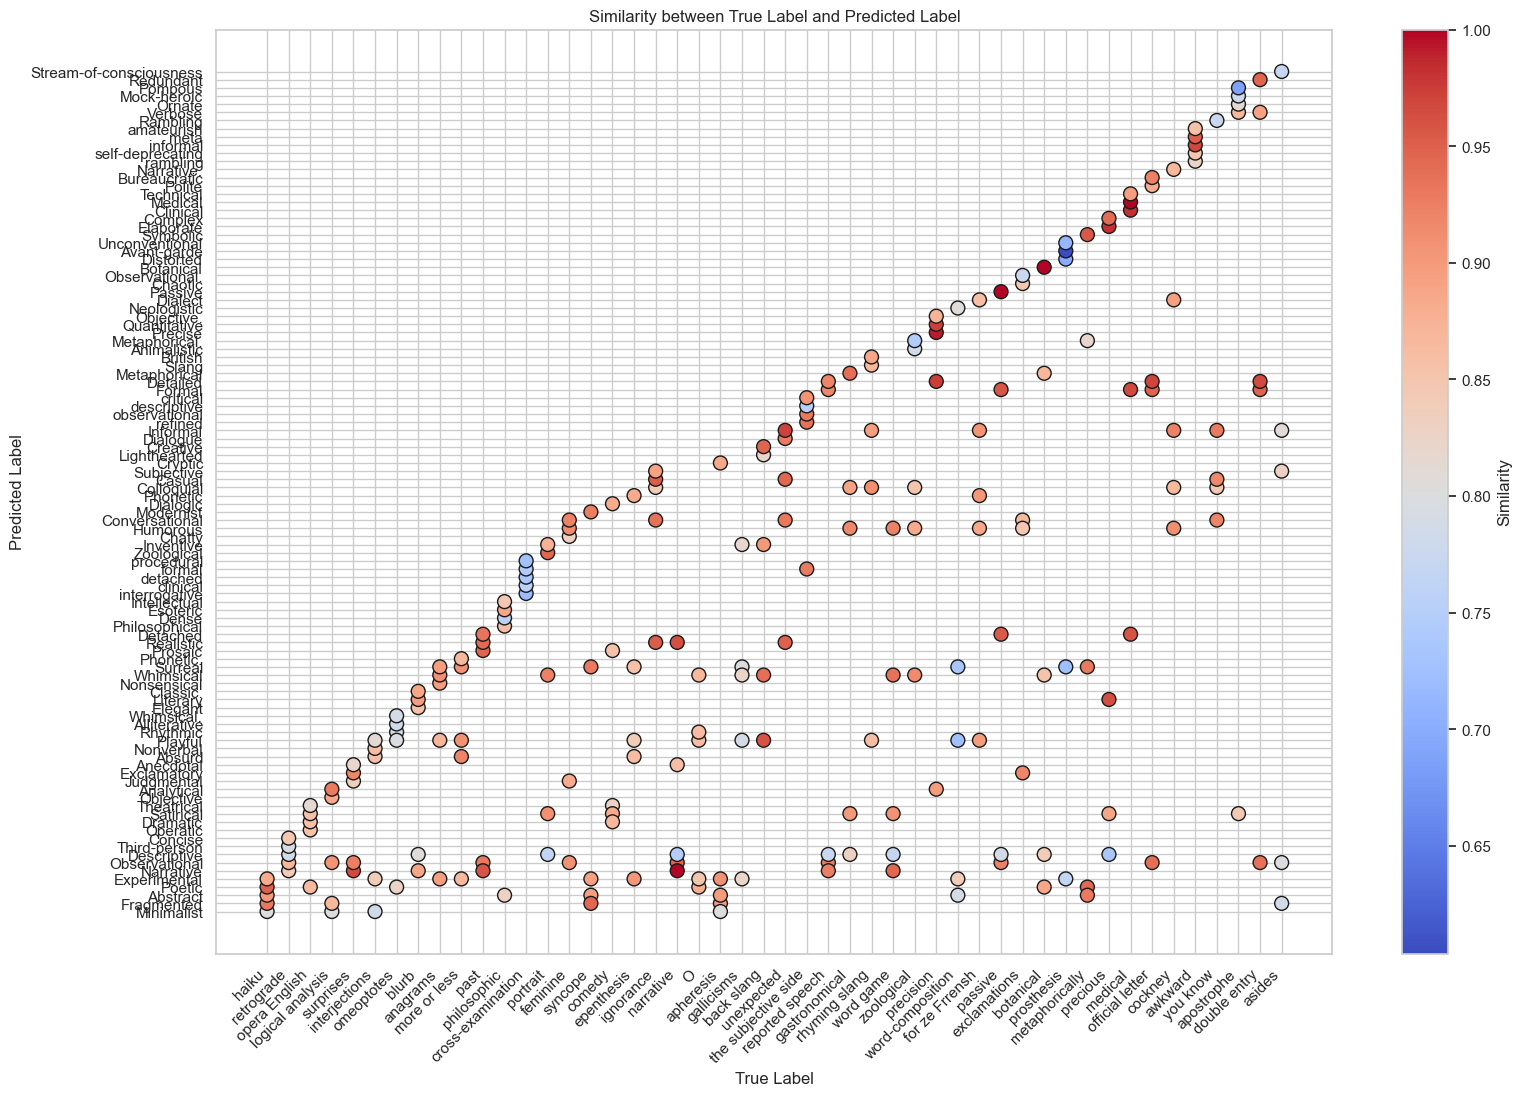

In [114]:
import numpy as np

# todo: rename the dfs in this notebook, because some are now overwritten...
results_df = pd.DataFrame(results)

# plot
plt.figure(figsize=(18, 12))
scatter = plt.scatter(
    x=results_df['True Label'], y=results_df['Predicted Label'], 
    c=results_df['Similarity'], cmap='coolwarm', s=100, edgecolor='k'
)
plt.colorbar(scatter, label='Similarity')
plt.xticks(rotation=45, ha='right')
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Similarity between True Label and Predicted Label')
plt.grid(True)
plt.show()

The similarity scores in this plot represent the cosine similarity between BERT embeddings of the true labels and the predicted labels. The true labels are the original styles of the stories, while the predicted labels are generated by the `GPT-3.5-turbo-0125` model. The scores measure how accurately the model can identify the style of rewritten stories after style transfer. Higher similarity scores (closer to 1) indicate that the predicted label is more semantically similar to the true label, whereas lower scores (closer to 0) indicate less similarity.

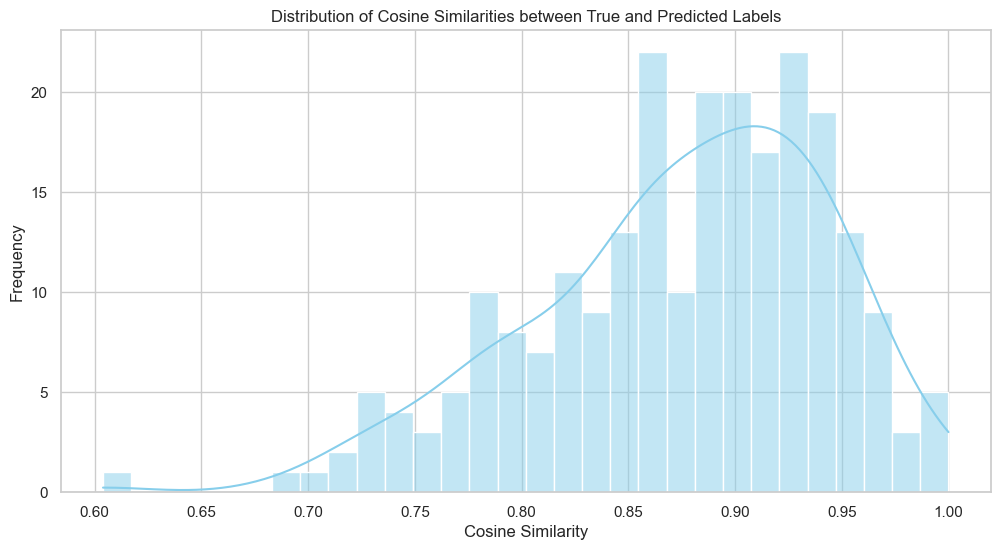

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot distribution of cosine similarities
plt.figure(figsize=(12, 6))
sns.histplot(results_df['Similarity'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Cosine Similarities between True and Predicted Labels')
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


### Further ideas (to be executed, or not)

- use Q's collection in one language to finetune a language model to recognize the style of a text in a different language. I.e. test the model on a set of stories from the same collection that have been translated into different languages.
- Experiment with different LLMs to see how they perform on the same task. Do different models have different strengths and weaknesses when it comes to recognizing literary styles?
- Examine the impact of explicitly providing label definitions to the model on its ability to accurately assign labels to stories. 
- Also see how self-assigned labels might improve based on definitions/short descriptions!
- Annotation experimebnts with human annotators to see how well they can assign labels to stories. This will help us understand how well humans can recognize and classify literary styles, and how their performance compares to that of LLMs.
- Metadiscussion on literry style, parody, pastische, bricolage.
- While we're questioning the models ability to understand the labels, we might also question the labels themselves and how Queneau understood them!

In [ ]:
## Sources and references

- https://gdt.hypotheses.org/1357
- https://collections.libraries.indiana.edu/lilly/exhibitions/exhibits/show/wright-ing-the-untranslatable

In [418]:
## tryout with LLAMA3 (using ollame API)

In [423]:
import ollama
response = ollama.chat(model='llama3', messages=[
  {
    'role': 'user',
    'content': "Please read the following story and assign the most appropriate title that best aligns with the stories literary features from these options: 'narrative' or 'metaphorically'. Respond with only the label name. For example, if the correct label is 'notation', reply 'notation'. This is the story: In the centre of the day, tossed among the shoal of travelling sardines in a coleopter with a big white carapace, a chicken with a long, feather-less neck suddenly harangued one, a peace-abiding one, of their number, and its parlance, moist with protest, was unfolded upon the airs. Then, attracted by a void, the fledgling precipitated itself thereunto. In a bleak, urban desert, I saw it again that selfsame day, drinking the cup of humiliation offered by a lowly button." ,
  },
])
print(response['message']['content'])

metaphorically
